In [15]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

img_dir = 'train'
mask_dir = 'train/masks'
excel_file = 'train/classif.xlsx'
data_feature_file = 'data_features.csv'

# Load classification file
def load_classification(excel_file):
    if os.path.exists(excel_file):
        return pd.read_excel(excel_file)
    else:
        print(f"Excel file {excel_file} not found.")
        return None

# Load features
def load_features(data_feature_file):
    if os.path.exists(data_feature_file):
        return pd.read_csv(data_feature_file)
    else:
        print(f"Feature file {data_feature_file} not found.")
        return None

classif_df = load_classification(excel_file)
features_df = load_features(data_feature_file)

# 处理标签
def process_labels(df):
    bug_types = []
    species = []
    
    for _, row in df.iterrows():
        bugs = row['bug_type']
        species_info = row['species']
        
        # 处理x2
        if ' x2' in species_info:
            bugs = [bugs.replace(' x2','')] * 2
            species_info = [species_info.replace(' x2','')] * 2
        else:
            bugs = bugs.split(' & ')
            species_info = species_info.split(' & ')
        
        # 处理问号
        bugs = [bug.replace(' ?', '') for bug in bugs]
        species_info = [specie.replace(' ?', '') for specie in species_info]
        
        bug_types.append(bugs)
        species.append(species_info)
    
    df['bug_type'] = bug_types
    df['species'] = species
    return df

classif_df = process_labels(classif_df)
print(classif_df.head())

# 使用MultiLabelBinarizer转换标签
mlb_bug_type = MultiLabelBinarizer()
mlb_species = MultiLabelBinarizer()

bug_type_encoded = mlb_bug_type.fit_transform(classif_df['bug_type'])
species_encoded = mlb_species.fit_transform(classif_df['species'])

# 转换为DataFrame
bug_type_df = pd.DataFrame(bug_type_encoded, columns=mlb_bug_type.classes_)
species_df = pd.DataFrame(species_encoded, columns=mlb_species.classes_)

# 合并所有数据
all_data_df = pd.concat([classif_df.drop(columns=['bug_type', 'species']), bug_type_df, species_df, features_df], axis=1)


   ID bug_type           species
0   1    [Bee]  [Apis mellifera]
1   2    [Bee]  [Apis mellifera]
2   3    [Bee]  [Apis mellifera]
3   4    [Bee]  [Apis mellifera]
4   5    [Bee]  [Apis mellifera]


C:\Users\romai\AppData\Local\Temp\ipykernel_13052\318696258.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values,  palette="viridis")


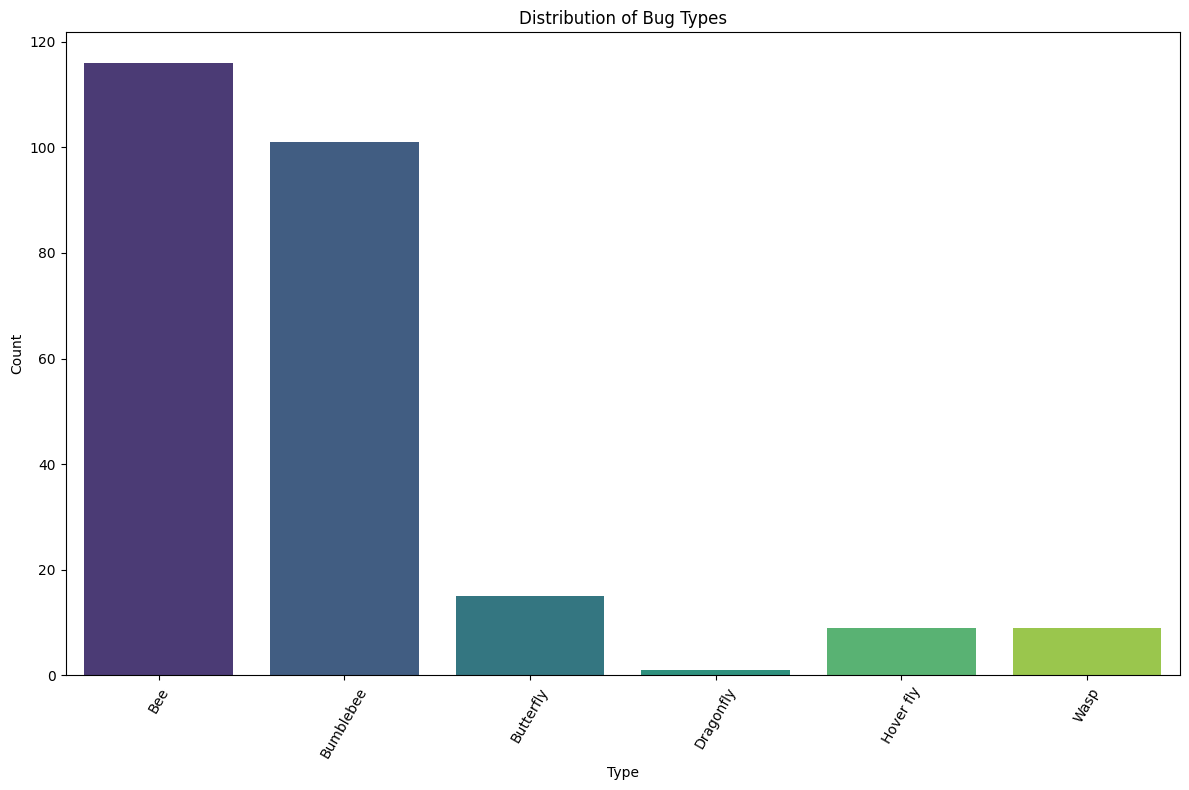

C:\Users\romai\AppData\Local\Temp\ipykernel_13052\318696258.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values,  palette="viridis")


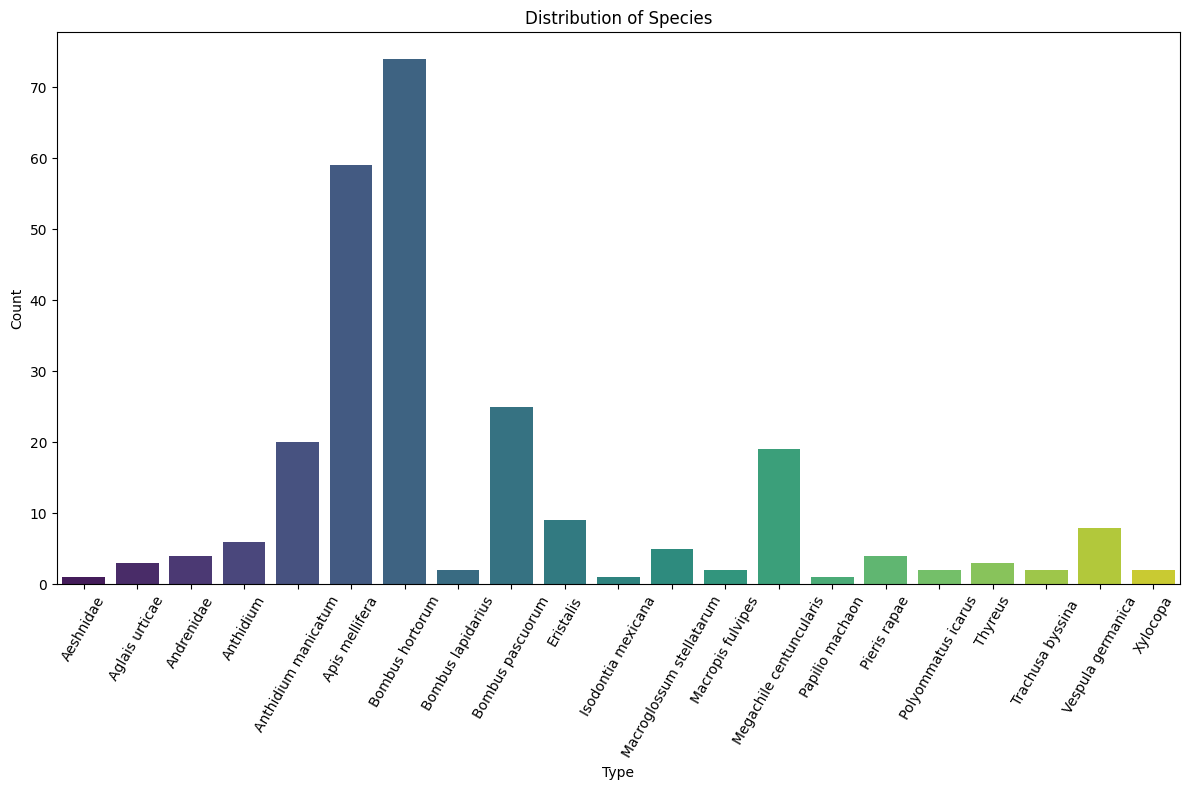

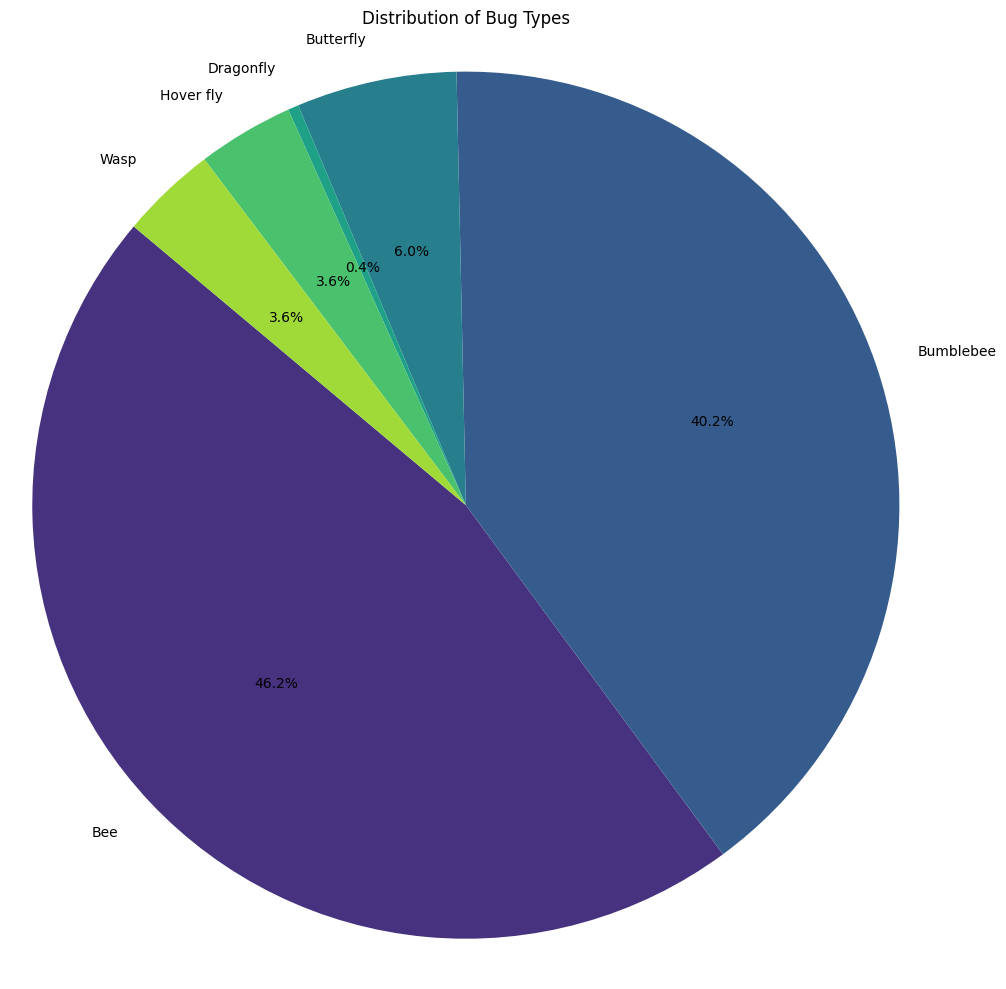

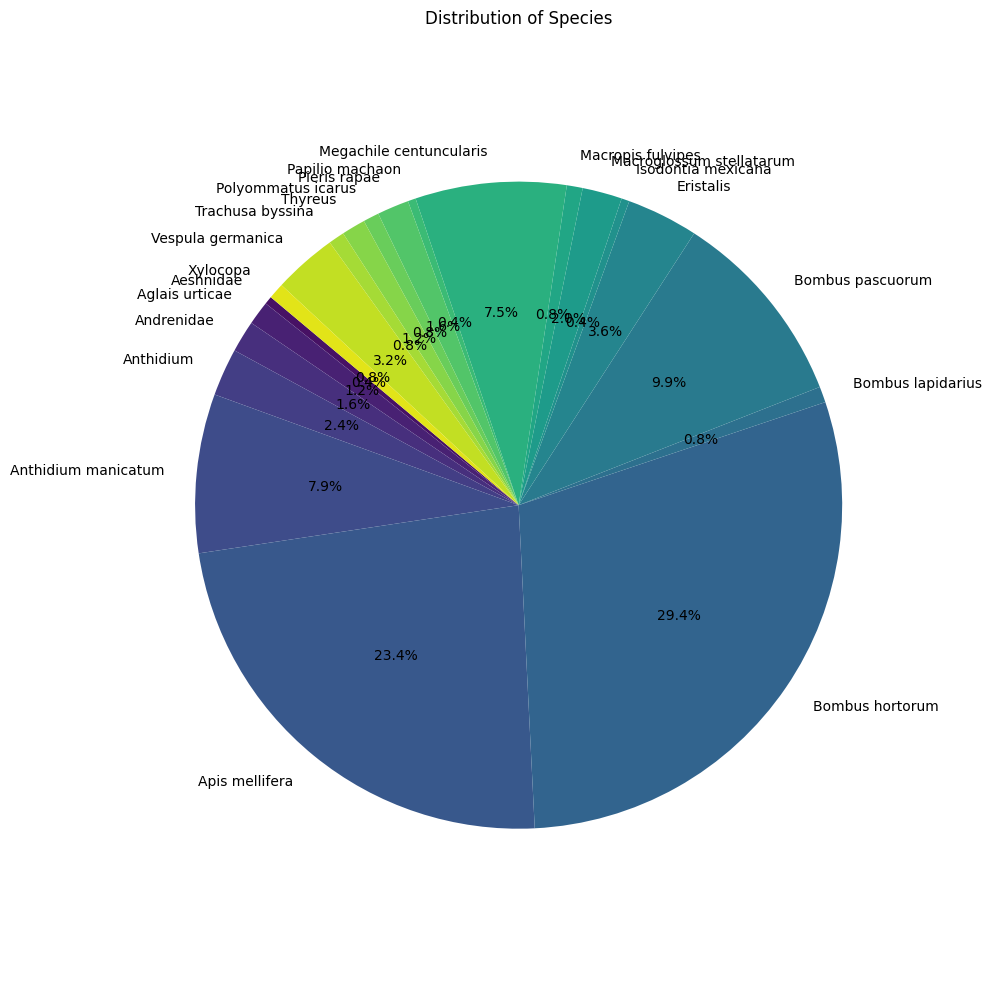

In [16]:
# 可视化分布
def plot_distribution(data, title):
    counts = data.sum()
    plt.figure(figsize=(12, 8))
    sns.barplot(x=counts.index, y=counts.values,  palette="viridis")
    plt.title(title)
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_distribution(bug_type_df, 'Distribution of Bug Types')
plot_distribution(species_df, 'Distribution of Species')

# 昆虫类型分布的饼图
def plot_pie_distribution(data, title):
    counts = data.sum()
    colors = sns.color_palette('viridis', len(counts))
    plt.figure(figsize=(10, 10))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140,colors=colors)
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout() 
    plt.show()

plot_pie_distribution(bug_type_df, 'Distribution of Bug Types')
plot_pie_distribution(species_df, 'Distribution of Species')


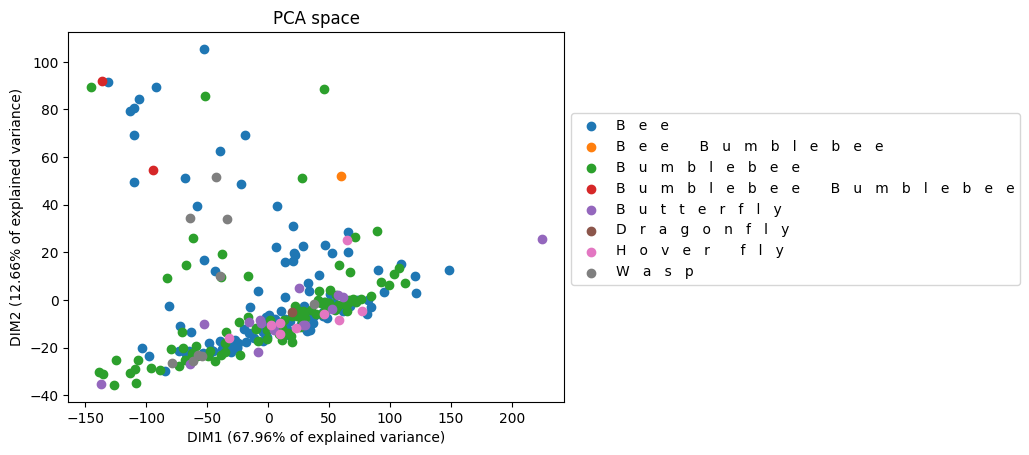

In [21]:
classif_df_string = classif_df
classif_df_string["bug_type"] = classif_df["bug_type"].apply(lambda x: ' '.join(x))
classif_df_string["species"] = classif_df["species"].apply(lambda x: ' '.join(x))

features = features_df

digit_class=classif_df_string["bug_type"]
dig_list=np.unique(digit_class.values)
pca = PCA(n_components=2)
digits_pca = pca.fit_transform(features)

pc1 = round(pca.explained_variance_ratio_[0] * 100,2)
pc2 = round(pca.explained_variance_ratio_[1] * 100,2)

fig, ax = plt.subplots();
for dig in dig_list:
    ax.scatter(digits_pca[digit_class==dig, 0], digits_pca[digit_class==dig, 1],label=dig);
ax.set_xlabel("DIM1 ({0}% of explained variance)".format(pc1, fontsize=11))
ax.set_ylabel("DIM2 ({0}% of explained variance)".format(pc2, fontsize=11))
ax.legend(bbox_to_anchor=(1, 0.8));    
ax.set_title('PCA space', fontsize=12);


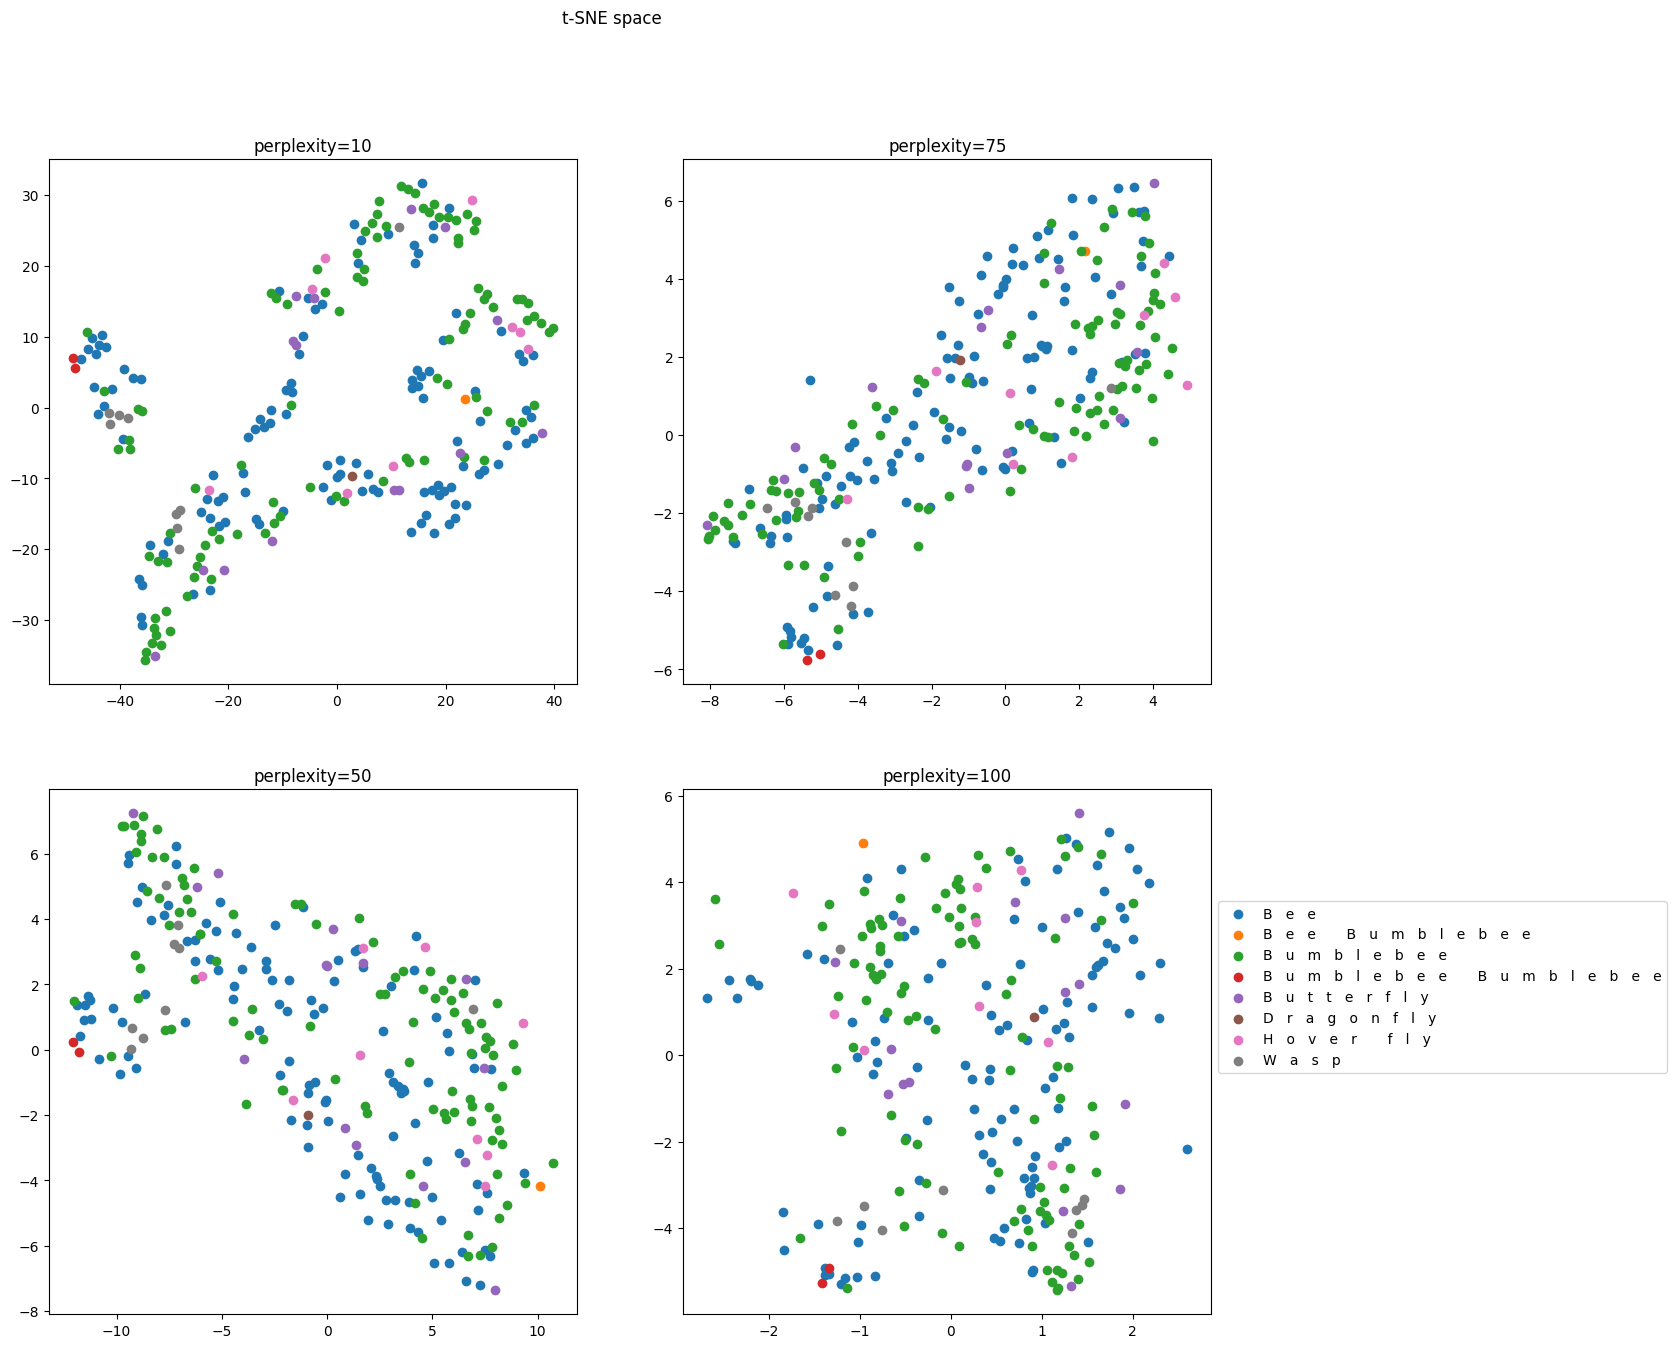

In [22]:
#TSNE
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap, TSNE

nb_lines = 2
nb_cols = 2

fig, ax = plt.subplots(nb_lines, nb_cols, figsize=(15, 15))
line_ids, col_ids = np.meshgrid(range(0, nb_lines), 
                                range(0, nb_cols))
fig.suptitle('t-SNE space', fontsize=12)
for perp, line_id, col_id in zip([10,50,75,100],
                                      line_ids.flatten(), col_ids.flatten()):
   model = TSNE(n_components=2,perplexity=perp, random_state=0)
   digits_tsne = model.fit_transform(features)
   for dig in dig_list:
         ax[line_id, col_id].scatter(digits_tsne[digit_class==dig, 0], digits_tsne[digit_class==dig, 1],label=dig);    
   
   ax[line_id, col_id].set_title("perplexity={0}".format(perp))
plt.legend(bbox_to_anchor=(1, 0.8));  

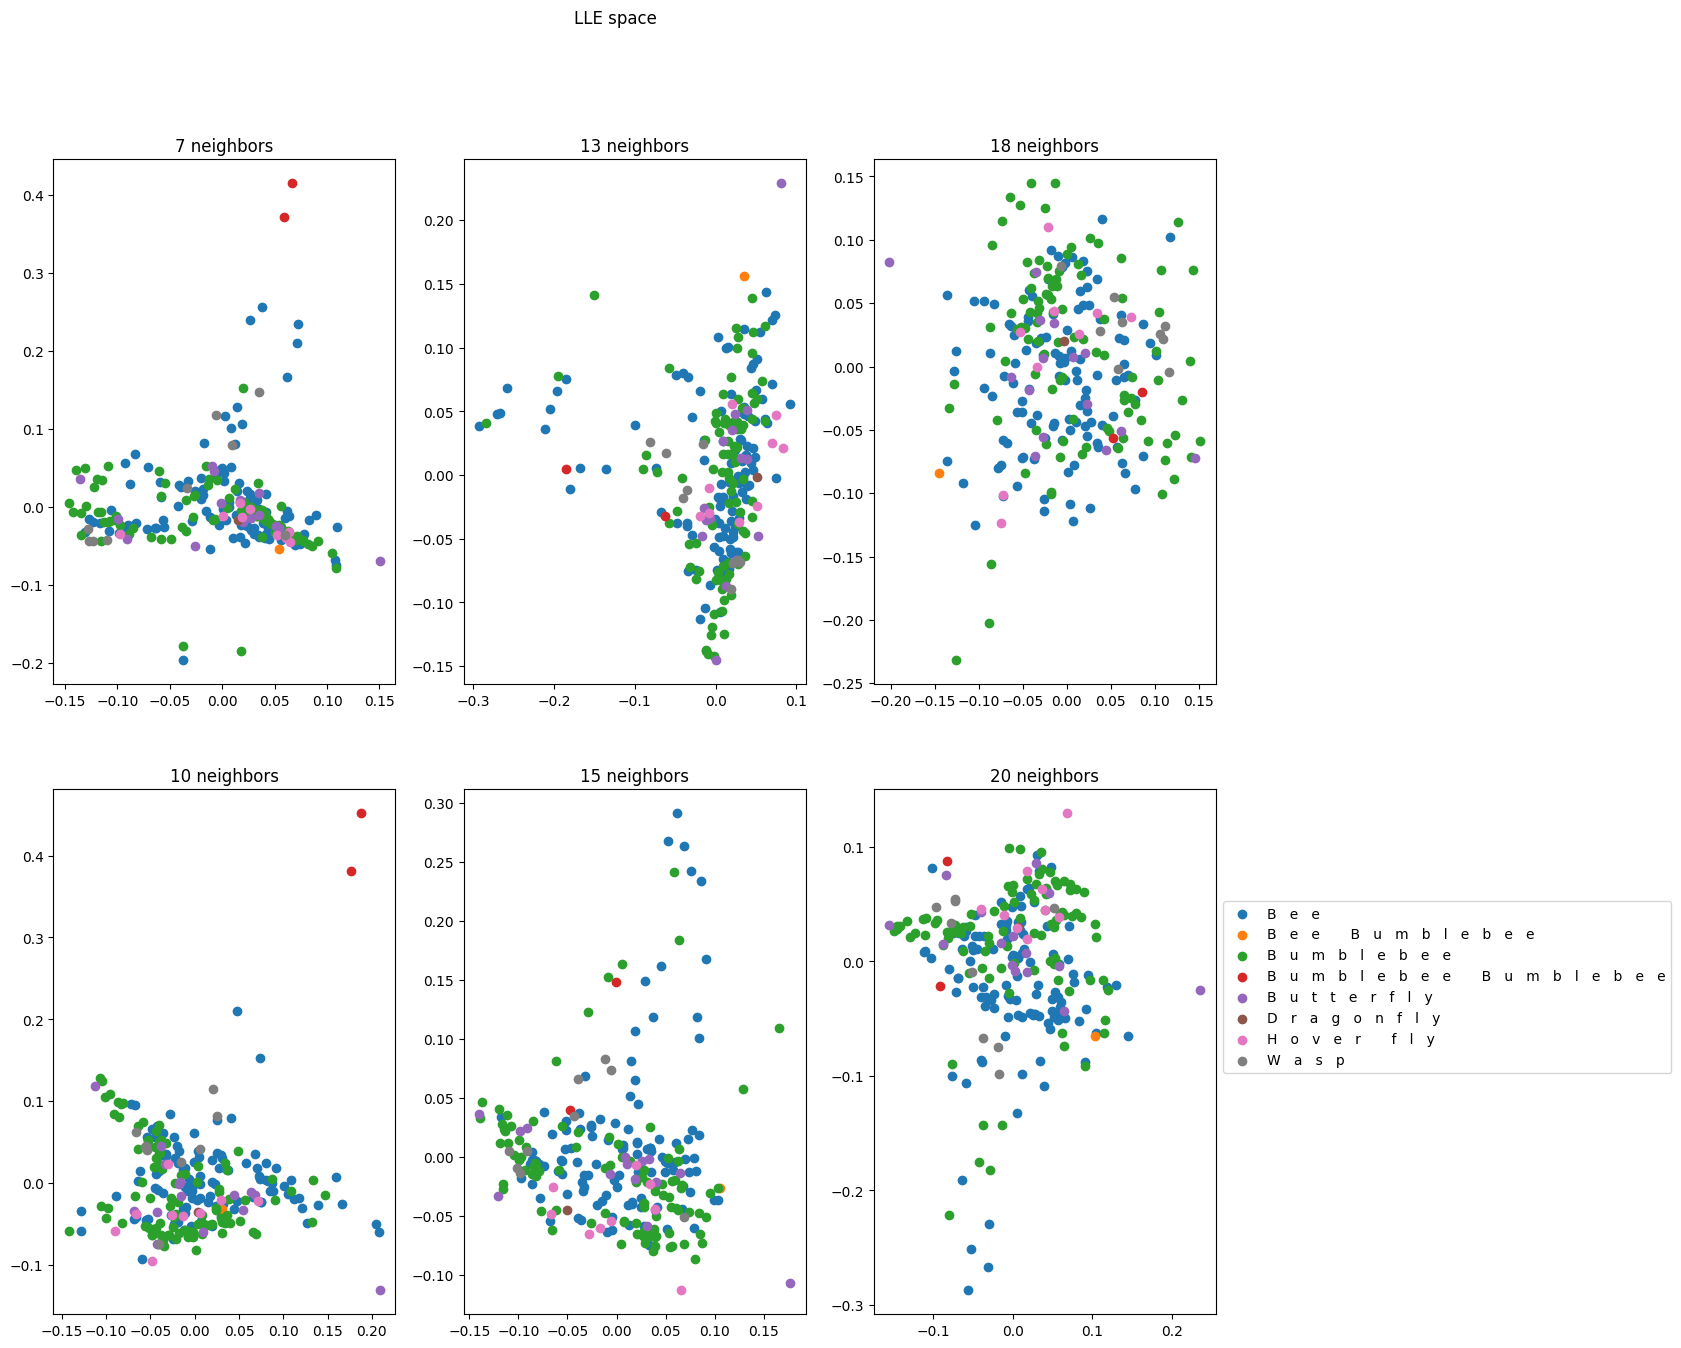

In [24]:
nb_lines = 2
nb_cols = 3

fig, ax = plt.subplots(nb_lines, nb_cols, figsize=(15, 15))
line_ids, col_ids = np.meshgrid(range(0, nb_lines), 
                                range(0, nb_cols))
fig.suptitle('LLE space', fontsize=12)
for n_neighbor, line_id, col_id in zip([7, 10, 13, 15, 18, 20],
                                      line_ids.flatten(), col_ids.flatten()):
   model = LocallyLinearEmbedding(n_neighbors=n_neighbor, random_state=0)
   digits_lle = model.fit_transform(features)
   for dig in dig_list:
         ax[line_id, col_id].scatter(digits_lle[digit_class==dig, 0], digits_lle[digit_class==dig, 1],label=dig);    
   
   ax[line_id, col_id].set_title("{0} neighbors".format(n_neighbor))
plt.legend(bbox_to_anchor=(1, 0.8));   

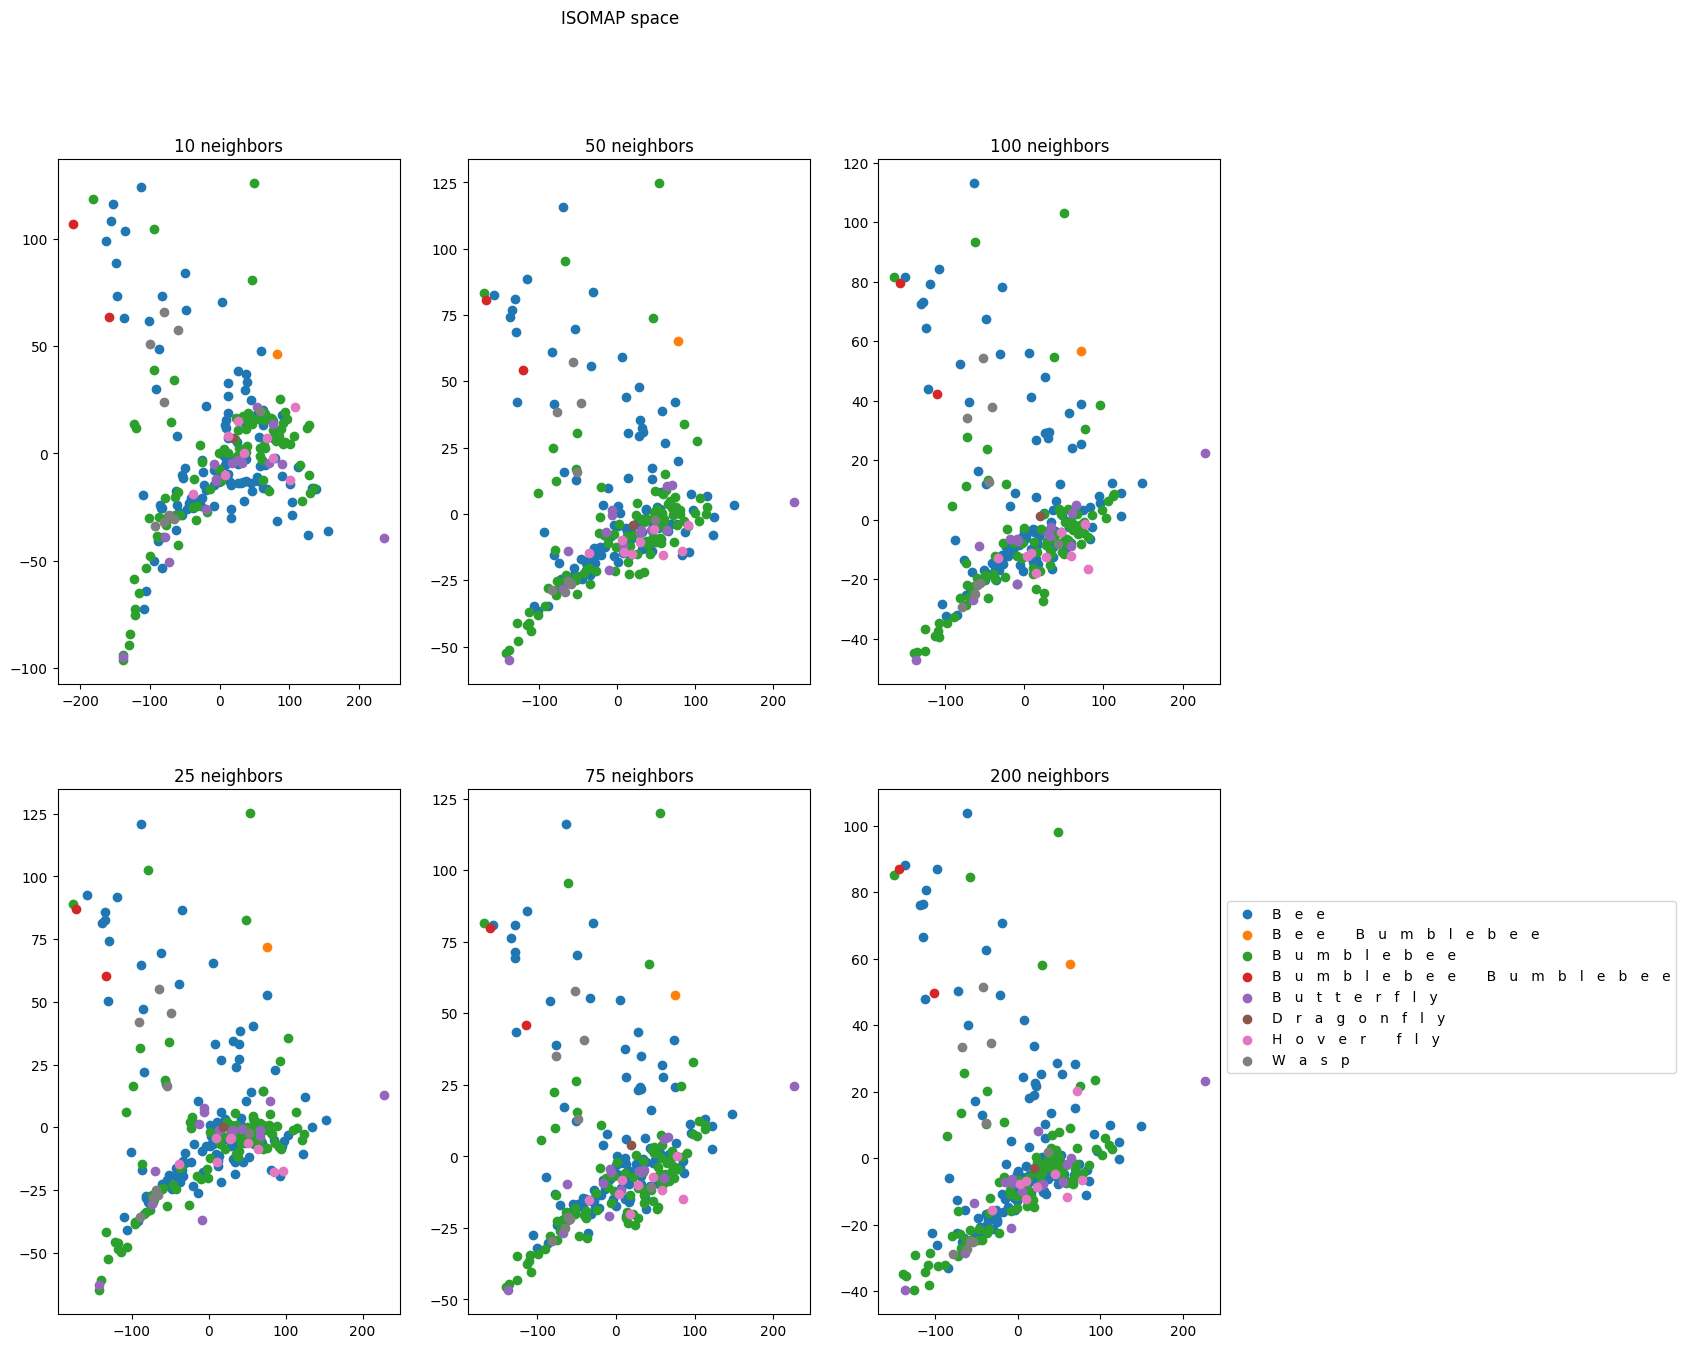

In [25]:
nb_lines = 2
nb_cols = 3

fig, ax = plt.subplots(nb_lines, nb_cols, figsize=(15, 15))
line_ids, col_ids = np.meshgrid(range(0, nb_lines), 
                                range(0, nb_cols))
fig.suptitle('ISOMAP space', fontsize=12)
for n_neighbor, line_id, col_id in zip([10, 25, 50, 75, 100, 200],
                                      line_ids.flatten(), col_ids.flatten()):
   model = Isomap(n_neighbors=n_neighbor)
   digits_lle = model.fit_transform(features)
   for dig in dig_list:
         ax[line_id, col_id].scatter(digits_lle[digit_class==dig, 0], digits_lle[digit_class==dig, 1],label=dig);    
   
   ax[line_id, col_id].set_title("{0} neighbors".format(n_neighbor))
plt.legend(bbox_to_anchor=(1, 0.8));   

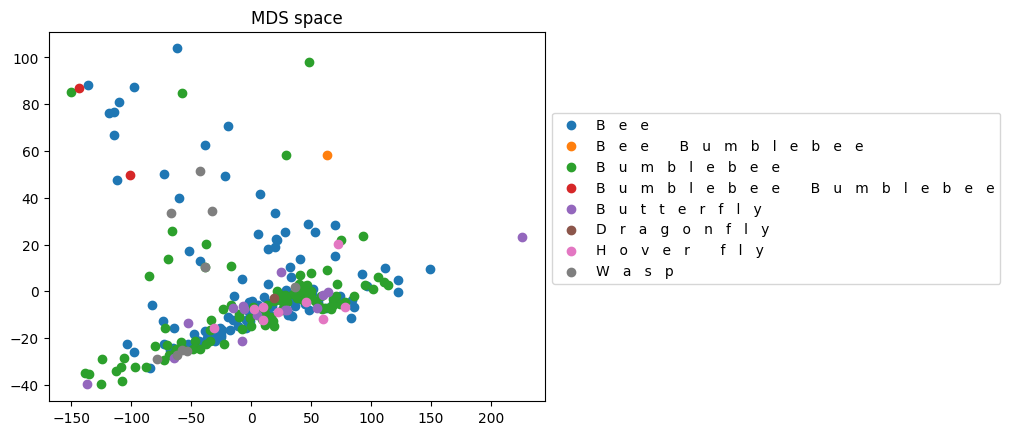

In [28]:
mds = MDS(random_state=0)
digits_mds = model.fit_transform(features)

fig, ax = plt.subplots();
for dig in dig_list:
     ax.scatter(digits_lle[digit_class==dig, 0], digits_lle[digit_class==dig, 1],label=dig); 
ax.legend(bbox_to_anchor=(1, 0.8));    
ax.set_title('MDS space', fontsize=12);            
